#Fine tuning BERT to classify movies request as similar or not

BERT is commonly used as follows for
entity matching: The string representations of two
entity descriptions are concatenated using *BERTs [CLS] Sequence
1 [SEP] Sequence 2 [SEP]* input scheme for sequence classification
tasks. The pooled output representation of the [CLS] token from
the last encoder layer is then used as input for a linear classification layer followed by sigmoid or softmax to obtain the final class
probabilities, in the case of entity matching, match and non-match.
The [CLS] token is used as a representation of the two sequences,
trained for a specific task. During BERT pre-training the [CLS]
token was tuned for the Next Sentence Prediction objective and is
adapted to the entity matching objective during fine-tuning for the
entity matching task.

As such BERT is well suited to classify two sequences as similar or not. Training BERT classifier will allow prunning reddit submissions set generated by the Reddit-Movie-Buff recommender.

##1. Fine tuning BERT classifier on training dataset

### 1.1. Prepare data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

In [4]:
import torch
import transformers
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn import metrics
from torch.utils.data import Dataset,  DataLoader, TensorDataset
import pandas as pd
import numpy as np
import transformers
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm

transformers.logging.set_verbosity_error()
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f'Device: {device}')

Device: cuda:0


In [6]:
import pickle

with open('/content/drive/MyDrive/ML/data/movies/reddit/bert_final_dataset.pkl', 'rb') as f:
    data = pickle.load(f)
    training_pairs = data['training_pairs']
    val_set = data['val_set']

len(training_pairs), len(val_set)

(55882, 1816)

In [ ]:
training_pairs[8381]

{'id': 'uz8q8w',
 'query': 'A Movie about The 13 Colonies of the USA. Hello everyone. This recommendation sounds weird, but I am studying the history of the 13 Colonies of the USA and how they first went to them and how they became what they are today. For this matter, I want to watch movies about this subject to understand the lectures better. Please recommend to me any movies related to that and that can help me understand their history better, thank you!',
 'distance': 0.71072614,
 'submission': "Movies in a post colonial setting. I like viewing documentaries on this subject.\nI know this is quite specific but do you know any movies that are in this setting that shows the realities of this history and how they affect people in present times as well? I'd prefer the genre to be **horror-thriller.**",
 'ranking': [('even the rain', 0.08333), ('house', 0.08333)],
 'MATCH': 0,
 'NO': 8938}

In [7]:
from torch.utils.data import Dataset
import torch

from transformers import AutoTokenizer

MAX_LEN = 512  # maximum sequence length for BERT
class BertDataset(Dataset):

    def __init__(self, pairs_dataset, tokenizer_name = 'bert-base-uncased', max_length = MAX_LEN):
        self.max_length = max_length
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.data = self._prepare_data(pairs_dataset)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        return self.data[index]

    def _prepare_data(self, pairs_dataset):

        sequence1 = [p[0] for p in pairs_dataset]
        sequence2 = [p[1] for p in pairs_dataset]
        self.labels = torch.tensor([p[2] for p in pairs_dataset]).to(device)

        features = []
        for i in range(len(sequence1)):
            tokenized_sample = self.tokenizer(sequence1[i], sequence2[i],
                                              padding='max_length',
                                              return_tensors="pt",
                                              truncation='longest_first',
                                              max_length=self.max_length).to(device)
            tokenized_sample['label'] = self.labels[i]
            features.append(tokenized_sample)

        return features

In [8]:
train_set_mapped = [(t['query'], t['submission'], t['MATCH'], t['id']) for t in training_pairs]
val_set_mapped = [(t['query'], t['submission'], t['MATCH']) for t in val_set]

In [9]:
dataset = BertDataset(train_set_mapped)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
dataset_val = BertDataset(val_set_mapped)
dataloader_val = DataLoader(dataset_val, batch_size=16, shuffle=False)

Set of training pairs has size of 55k, validation set is 1816 examples (relatively small but the same set is used for SetFit validation, and SetFit method has smaller training dataset).

In [ ]:
len(dataset), len(dataset_val)

(55882, 1816)

### 1. 2. Get BERT

In [ ]:
torch.set_grad_enabled(True)
model= BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device) #
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
loss_fn = torch.nn.CrossEntropyLoss()
#Initialize Optimizer
optimizer= optim.Adam(model.parameters(), lr=1e-5)

### 1.3. Run training

In [ ]:
def set_seed(seed=42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
set_seed()

In [ ]:
from sklearn import metrics
from torch.utils.data import DataLoader, TensorDataset

# eval the model
def eval_model(epoch, dataloader_val, val_set, model, prev_best=0, save_best=True, save_path = 'bert_model_aug'):

    model.eval()
    predictions = []
    loop=tqdm(enumerate(dataloader_val),leave=False,total=len(dataloader_val))
    for i, batch in loop:
        with torch.no_grad():

            input_ids = batch['input_ids'].squeeze().to(device)
            attention_masks = batch['attention_mask'].squeeze().to(device)
            token_type_ids = batch['token_type_ids'].squeeze().to(device)

            outputs = model(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids,  labels=None)
            pred = np.argmax(outputs.logits.cpu(), axis=1)
            predictions.extend([p.item() for p in pred])
    labels = [p[2] for p in val_set]
    print(f'--- EVAL EPOCH {epoch} ---')
    res = metrics.classification_report(labels, predictions, output_dict=True)
    print(metrics.classification_report(labels, predictions))
    # save model if metric is higher than before
    if '1' in res:
        best_score = res['1']['f1-score']
        if save_best and best_score > prev_best:
            print(f'Saving model with best F1-score {best_score}...')
            model.save_pretrained(f'/content/drive/MyDrive/ML/data/movies/{save_path}')
            return best_score

    return prev_best


In [ ]:
from sklearn import metrics
# train the model
def train_model(model, epochs, dataloader, dataloader_val, val_set):
    model.train()
    best_score = 0
    for epoch in range(epochs):
        loop=tqdm(enumerate(dataloader), leave=False, total=len(dataloader))
        for i, batch in loop:
            input_ids = batch['input_ids'].squeeze().to(device)
            attention_masks = batch['attention_mask'].squeeze().to(device)
            token_type_ids = batch['token_type_ids'].squeeze().to(device)
            labels = batch['label'].to(device).long()

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids,  labels=labels)
            loss = loss_fn(outputs.logits, labels)
            loss.backward()
            optimizer.step()


            pred = list(np.argmax(outputs.logits.detach().cpu(), axis = 1))
            lbls = list(np.array(labels.cpu()))
            # print(pred, lbls)
            num_correct = sum(1 for a, b in zip(pred, lbls) if a == b)
            num_samples = len(pred)
            accuracy = num_correct/num_samples
            res = metrics.classification_report(lbls, pred, output_dict=True)

            if i % 200 == 0:
                if '1' in res:
                    print(f"F1-score for positive class is: {res['1']['f1-score']}")
                if '0' in res:
                    print(f"F1-score for negative class is: {res['0']['f1-score']}")

                # Show progress while training
                loop.set_description(f'Epoch={epoch}/{epochs}')
                loop.set_postfix(loss=loss.item(),acc=accuracy)


        best_score = eval_model(epoch, dataloader_val, val_set, model, prev_best = best_score)
        model.train()

train_model(model, 8, dataloader, dataloader_val, val_set_mapped)

###1.4. Evaluate results

In [ ]:
# 3 epochs full set balanced with BertForSequenceClassification
labels = [p['MATCH'] for p in val_set]
print(metrics.classification_report(labels, predictions)) #3 epochs

              precision    recall  f1-score   support

           0       0.76      0.58      0.65       816
           1       0.71      0.85      0.77      1000

    accuracy                           0.73      1816
   macro avg       0.73      0.71      0.71      1816
weighted avg       0.73      0.73      0.72      1816



In [ ]:
--- EPOCH 3 ---
                precision    recall  f1-score   support

           0       0.76      0.58      0.65       816
           1       0.71      0.85      0.77      1000

    accuracy                           0.73      1816
   macro avg       0.73      0.71      0.71      1816
weighted avg       0.73      0.73      0.72      1816

--- EPOCH 4 ---

                precision    recall  f1-score   support

           0       0.76      0.63      0.69       816
           1       0.73      0.84      0.78      1000

    accuracy                           0.74      1816
   macro avg       0.75      0.73      0.74      1816
weighted avg       0.75      0.74      0.74      1816

--- EPOCH 6 ---
              precision    recall  f1-score   support

           0       0.73      0.72      0.73       816
           1       0.78      0.78      0.78      1000

    accuracy                           0.76      1816
   macro avg       0.75      0.75      0.75      1816
weighted avg       0.76      0.76      0.76      1816

--- EPOCH 8 ---

              precision    recall  f1-score   support

           0       0.75      0.62      0.68       816
           1       0.73      0.83      0.78      1000

    accuracy                           0.74      1816
   macro avg       0.74      0.73      0.73      1816
weighted avg       0.74      0.74      0.73      1816

--- EPOCH 9 ---
              precision    recall  f1-score   support

           0       0.76      0.60      0.67       816
           1       0.72      0.84      0.78      1000

    accuracy                           0.73      1816
   macro avg       0.74      0.72      0.72      1816
weighted avg       0.74      0.73      0.73      1816

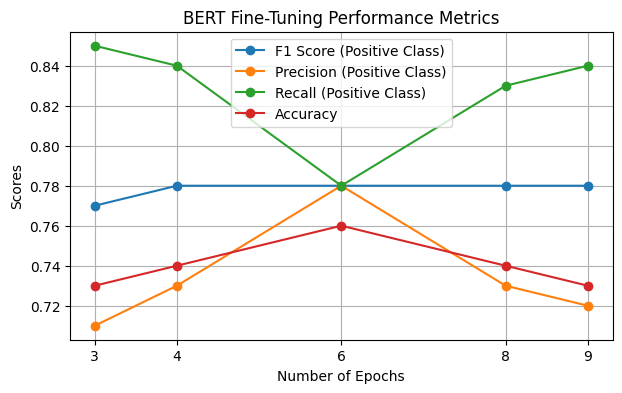

In [ ]:
import matplotlib.pyplot as plt

epochs = [3, 4, 6, 8, 9]
pos_f1 = [0.77, 0.78, 0.78, 0.78, 0.78]
pos_prec = [0.71, 0.73, 0.78, 0.73, 0.72]
pos_rec = [0.85, 0.84, 0.78, 0.83, 0.84]
acc = [0.73, 0.74, 0.76, 0.74, 0.73]

plt.figure(figsize=(7, 4))

# Plot F1 score
plt.plot(epochs, pos_f1, marker='o', label='F1 Score (Positive Class)')

# Plot precision
plt.plot(epochs, pos_prec, marker='o', label='Precision (Positive Class)')

# Plot recall
plt.plot(epochs, pos_rec, marker='o', label='Recall (Positive Class)')

# Plot accuracy
plt.plot(epochs, acc, marker='o', label='Accuracy')

plt.title('BERT Fine-Tuning Performance Metrics')
plt.xlabel('Number of Epochs')
plt.ylabel('Scores')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()

#### What is the AUC-ROC for both BERT and BERT augmented classifiers?

ROC (Receiver Operating Characteristic) plots are used in binary classification to visualize and assess the performance of a classifier. They plot the relationship between the True Positive Rate (TPR) and the False Positive Rate (FPR) across different decision thresholds or cutoff values.

The area under the ROC curve (AUC-ROC) summarizes the overall performance of the classifier. A higher AUC-ROC value (closer to 1) suggests better classification performance, while 0.5 indicates random chance (no discrimination). Values above 0.8 are considered to belong to well trained classifiers.

In [10]:
torch.set_grad_enabled(True)
model_path = '/content/drive/MyDrive/ML/data/movies/bert_model_full_6ps'
model= BertForSequenceClassification.from_pretrained(model_path, num_labels=2).to(device)
model_aug_path = '/content/drive/MyDrive/ML/data/movies/bert_model_aug'
model_aug= BertForSequenceClassification.from_pretrained(model_aug_path, num_labels=2).to(device)

In [13]:
def get_auc_stats(model):
    model.eval()
    probabilities = []
    loop=tqdm(enumerate(dataloader_val),leave=False,total=len(dataloader_val))
    for i, batch in loop:
        with torch.no_grad():

            input_ids = batch['input_ids'].squeeze().to(device)
            attention_masks = batch['attention_mask'].squeeze().to(device)
            token_type_ids = batch['token_type_ids'].squeeze().to(device)

            outputs = model(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids,  labels=None)
            # Apply softmax to obtain probabilities
            logits = np.array(outputs.logits.cpu())
            logits_sum = np.sum(np.exp(logits), axis=1)
            # Use np.repeat to repeat each element twice for element wise division
            logits_sum2 = np.repeat(logits_sum[:, np.newaxis], 2, axis=1)
            probs = np.divide(np.exp(logits), logits_sum2 )
            pred = probs[:, 1]
            probabilities.extend(pred)
    labels = [p[2] for p in val_set_mapped]
    return probabilities, labels

In [14]:
probabilities, labels = get_auc_stats(model)

In [15]:
probabilities_aug, labels_aug = get_auc_stats(model_aug)

ROC AUC: 0.8355876225490196, ROC AUC augmented 0.8403014705882355


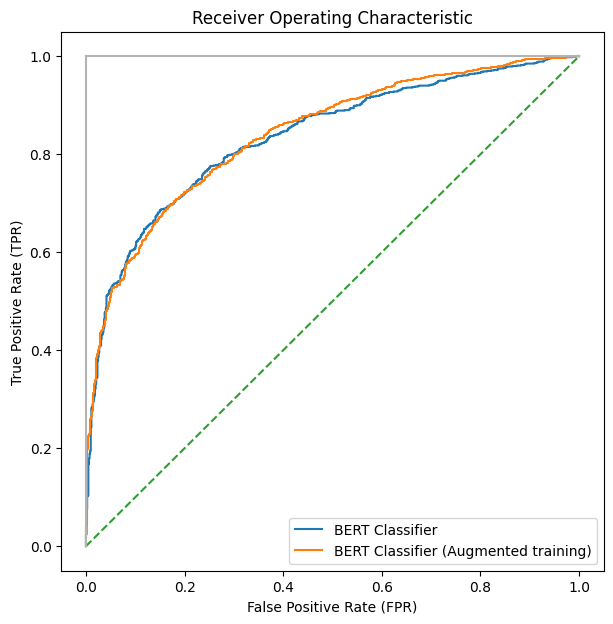

In [24]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

auc = roc_auc_score(labels, probabilities)
auc_aug = roc_auc_score(labels_aug, probabilities_aug)
print(f'ROC AUC: {auc}, ROC AUC augmented {auc_aug}')

fpr, tpr, thres = roc_curve(labels, probabilities)
fpr2, tpr2, thres2 = roc_curve(labels, probabilities_aug)

plt.subplots(1, figsize=(7,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label="BERT Classifier")
plt.plot(fpr2, tpr2, label="BERT Classifier (Augmented training)")
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')
plt.legend()
plt.show()



In [27]:
import pickle

with open('/content/drive/MyDrive/ML/data/movies/bert_val_set_preds.pkl', 'wb') as f:
    print('Saving probabilities...')
    pickle.dump({'probabilities': probabilities,
                 'probabilities_aug': probabilities_aug,
                  'labels': labels
            }, f)

Saving probabilities...


##2. Running the same BERT training on augmented training dataset

###2.1. Augment dataset

In [ ]:
!pip install nlpaug transformers

Augment submissions with a mixture of changes:
- insert or sumstitute words with similar words in the sentences (using BERT model)
- crop, swap words from the submissions
- swap and delete letters from the sentences

In [ ]:
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import random
import numpy as np

def define_augmenter():
    np.random.seed(42)

    stopwords = []
    aug_arr = []
    aug_arr.append(naw.ContextualWordEmbsAug( action='substitute', model_path='bert-base-uncased', device='cuda'))
    aug_arr.append(naw.ContextualWordEmbsAug(action='insert', device='cuda'))

    aug_arr.append(naw.RandomWordAug(aug_p = 0.2, action='crop', aug_min=1, aug_max = 6))
    aug_arr.append(naw.RandomWordAug(aug_p = 0.2, action='swap', aug_min=2, aug_max = 9))
    aug_arr.append(naw.ContextualWordEmbsAug( action='substitute', model_path='bert-base-uncased', device='cuda'))
    aug_arr.append(naw.ContextualWordEmbsAug(action='insert', device='cuda'))

    aug_arr.append( nac.RandomCharAug(aug_char_p=0.2, action='swap', aug_char_min =3, aug_char_max=8, include_numeric=False))
    aug_arr.append(nac.RandomCharAug(aug_char_p=0.2, action='delete', aug_char_min =1, aug_char_max=7))

    return aug_arr

aug_arr = define_augmenter()

In [ ]:
sent = 'War is old men talking and young men dying'
aug_arr[0].augment(sent)[0], aug_arr[1].augment(sent)[0]

('war is of men talking in young men from',
 'this war is here old men talking and crying young men dying')

In [ ]:
train_set_mapped[9], aug_arr[0].augment(train_set_mapped[9][0])[0], aug_arr[1].augment(train_set_mapped[9][1])[0], aug_arr[3].augment(train_set_mapped[9][1])[0]

(("I'm looking for movies similar to Arizona Dream.I love the way the story is told as well as how wacky some of the events are. What are some other movies like that?",
  'Movies like The Florida Project or Nomadland. I’m not sure what this genre is called but does anyone have any suggestions for movies that are similar to The Florida Project or Nomadland? I like the way both films are shot as well as the plot.',
  0.0,
  'kh95xh'),
 "i'm looking with movies similar to arizona dream. i think the mode the story is told extremely well as though wacky some on our episodes are. there are some other movies doing that?",
 'movies are like the florida film project or nomadland. i ’ m pretty not sure what this genre is called anymore but so does anyone have any suggestions for movies that are similar to get the florida project or nomadland? i like on the way that both films are shot successfully as well as set the plot.',
 'Movies like The Florida Project Nomadland or. I ’ not m sure what this

In [ ]:
def augment(datapoint, aug_arr):
    # choose if this sample is going to be augmented - let's augment with prob 50%
    if np.random.rand() >= 0.45:
        # select augmenter index from arr of augmenters
        ind = int(np.round(np.random.rand() * (len(aug_arr) - 1)))
        try:
            aug_sample = aug_arr[ind].augment(datapoint)[0]
            return aug_sample
        except:
            return False
    return False

augmented_data = []
def augment_dataset(data, augmented_data):
  aug_arr = define_augmenter()
  augmented_data = []

  for i, d in enumerate(data):
    if i % 100 == 0:
        print(i)
    augmented_data.append(d)
    d0 = augment(d[0], aug_arr)
    d1 = augment(d[1], aug_arr)
    if not d0 and not d1:
      continue

    augmented_data.append((d0 if d0 else d[0], d1 if d1 else d[1], d[2], d[3]))

  return augmented_data

training_aug = augment_dataset(train_set_mapped, augmented_data)


len(train_set_mapped), len(training_aug), len(training_aug) / len(train_set_mapped)

In [ ]:
len(training_aug), len(val_set)

(100520, 1816)

After augmentation there is 45% more data points

In [ ]:
import pickle

with open('/content/drive/MyDrive/ML/data/movies/reddit/bert_final_aug_dataset.pkl', 'wb') as f:
    print('Saving dataset...')
    pickle.dump({'training_pairs': training_aug,
                    'val_set': val_set
            }, f)

Saving dataset...


### 2.2. Prepare data

In [ ]:
!pip install transformers

In [ ]:
import pickle

with open('/content/drive/MyDrive/ML/data/movies/reddit/bert_final_aug_dataset.pkl', 'rb') as f:
    data = pickle.load(f)
    training_pairs = data['training_pairs']
    val_set = data['val_set']

len(training_pairs), len(val_set)

(100520, 1816)

In [ ]:
train_set_mapped = [(t['query'], t['submission'], t['MATCH'], t['id']) for t in training_pairs]
val_set_mapped = [(t['query'], t['submission'], t['MATCH'], t['id']) for t in val_set]

In [ ]:
import torch
import transformers
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn import metrics
from torch.utils.data import Dataset,  DataLoader, TensorDataset
import pandas as pd
import numpy as np
import transformers
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm

transformers.logging.set_verbosity_error()
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f'Device: {device}')

torch.set_grad_enabled(True)
model= BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device) #
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
loss_fn = torch.nn.CrossEntropyLoss()
#Initialize Optimizer
optimizer= optim.Adam(model.parameters(), lr=1e-5)

Device: cuda:0


In [ ]:
dataset = BertDataset(train_set_mapped)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
dataset_val = BertDataset(val_set_mapped)
dataloader_val = DataLoader(dataset_val, batch_size=16, shuffle=False)
len(dataset), len(dataset_val)

(100520, 1816)

In [ ]:
set_seed()

###2.3. Train model on augmented dataset

In [ ]:
train_model(model, 4, dataloader, dataloader_val, val_set_mapped)   # train for 4 epochs

Epoch=0/1:   0%|          | 1/6283 [00:00<1:41:55,  1.03it/s, acc=0.5, loss=0.76]

F1-score for positive class is: 0.6
F1-score for negative class is: 0.3333333333333333


Epoch=0/1:   3%|▎         | 201/6283 [01:32<46:17,  2.19it/s, acc=0.812, loss=0.368]

F1-score for positive class is: 0.823529411764706
F1-score for negative class is: 0.7999999999999999


Epoch=0/1:   6%|▋         | 401/6283 [03:04<45:09,  2.17it/s, acc=0.938, loss=0.295]

F1-score for positive class is: 0.9333333333333333
F1-score for negative class is: 0.9411764705882353


Epoch=0/1:  10%|▉         | 601/6283 [04:36<43:23,  2.18it/s, acc=0.938, loss=0.213]

F1-score for positive class is: 0.9473684210526316
F1-score for negative class is: 0.923076923076923


Epoch=0/1:  13%|█▎        | 801/6283 [06:07<41:45,  2.19it/s, acc=0.688, loss=0.515]

F1-score for positive class is: 0.5454545454545454
F1-score for negative class is: 0.761904761904762


Epoch=0/1:  16%|█▌        | 1001/6283 [07:39<40:25,  2.18it/s, acc=0.688, loss=0.338]

F1-score for positive class is: 0.6153846153846153
F1-score for negative class is: 0.7368421052631577


Epoch=0/1:  19%|█▉        | 1201/6283 [09:11<39:26,  2.15it/s, acc=0.75, loss=0.428]

F1-score for positive class is: 0.7777777777777778
F1-score for negative class is: 0.7142857142857143


Epoch=0/1:  22%|██▏       | 1401/6283 [10:43<37:17,  2.18it/s, acc=0.812, loss=0.379]

F1-score for positive class is: 0.8
F1-score for negative class is: 0.8235294117647058


Epoch=0/1:  25%|██▌       | 1601/6283 [12:14<35:46,  2.18it/s, acc=0.938, loss=0.196]

F1-score for positive class is: 0.9411764705882353
F1-score for negative class is: 0.9333333333333333


Epoch=0/1:  29%|██▊       | 1801/6283 [13:46<34:34,  2.16it/s, acc=1, loss=0.0961]

F1-score for positive class is: 1.0
F1-score for negative class is: 1.0


Epoch=0/1:  32%|███▏      | 2001/6283 [15:18<32:53,  2.17it/s, acc=0.812, loss=0.45]

F1-score for positive class is: 0.8
F1-score for negative class is: 0.8235294117647058


Epoch=0/1:  35%|███▌      | 2201/6283 [16:50<31:31,  2.16it/s, acc=0.812, loss=0.519]

F1-score for positive class is: 0.8421052631578948
F1-score for negative class is: 0.7692307692307693


Epoch=0/1:  38%|███▊      | 2401/6283 [18:22<30:11,  2.14it/s, acc=0.938, loss=0.106]

F1-score for positive class is: 0.9473684210526316
F1-score for negative class is: 0.923076923076923


Epoch=0/1:  41%|████▏     | 2601/6283 [19:53<28:26,  2.16it/s, acc=0.875, loss=0.463]

F1-score for positive class is: 0.9166666666666666
F1-score for negative class is: 0.7499999999999999


Epoch=0/1:  45%|████▍     | 2801/6283 [21:25<26:56,  2.15it/s, acc=0.812, loss=0.326]

F1-score for positive class is: 0.8421052631578948
F1-score for negative class is: 0.7692307692307692


Epoch=0/1:  48%|████▊     | 3001/6283 [22:57<25:13,  2.17it/s, acc=0.938, loss=0.0607]

F1-score for positive class is: 0.9411764705882353
F1-score for negative class is: 0.9333333333333333


Epoch=0/1:  51%|█████     | 3201/6283 [24:29<23:51,  2.15it/s, acc=0.812, loss=0.431]

F1-score for positive class is: 0.8421052631578948
F1-score for negative class is: 0.7692307692307692


Epoch=0/1:  54%|█████▍    | 3401/6283 [26:00<22:18,  2.15it/s, acc=1, loss=0.0327]

F1-score for positive class is: 1.0
F1-score for negative class is: 1.0


Epoch=0/1:  57%|█████▋    | 3601/6283 [27:32<20:37,  2.17it/s, acc=1, loss=0.0613]

F1-score for positive class is: 1.0
F1-score for negative class is: 1.0


Epoch=0/1:  60%|██████    | 3801/6283 [29:04<18:58,  2.18it/s, acc=1, loss=0.0304]

F1-score for positive class is: 1.0
F1-score for negative class is: 1.0


Epoch=0/1:  64%|██████▎   | 4001/6283 [30:36<17:24,  2.19it/s, acc=0.938, loss=0.14]

F1-score for positive class is: 0.923076923076923
F1-score for negative class is: 0.9473684210526316


Epoch=0/1:  67%|██████▋   | 4201/6283 [32:07<15:55,  2.18it/s, acc=0.938, loss=0.282]

F1-score for positive class is: 0.9565217391304348
F1-score for negative class is: 0.888888888888889


Epoch=0/1:  70%|███████   | 4401/6283 [33:39<14:23,  2.18it/s, acc=1, loss=0.118]

F1-score for positive class is: 1.0
F1-score for negative class is: 1.0


Epoch=0/1:  73%|███████▎  | 4601/6283 [35:11<13:07,  2.14it/s, acc=1, loss=0.0522]

F1-score for positive class is: 1.0
F1-score for negative class is: 1.0


Epoch=0/1:  76%|███████▋  | 4801/6283 [36:43<11:18,  2.18it/s, acc=0.938, loss=0.224]

F1-score for positive class is: 0.9473684210526316
F1-score for negative class is: 0.923076923076923


Epoch=0/1:  80%|███████▉  | 5001/6283 [38:15<09:49,  2.18it/s, acc=0.938, loss=0.108]

F1-score for positive class is: 0.9090909090909091
F1-score for negative class is: 0.9523809523809523


Epoch=0/1:  83%|████████▎ | 5201/6283 [39:47<08:23,  2.15it/s, acc=1, loss=0.064]

F1-score for positive class is: 1.0
F1-score for negative class is: 1.0


Epoch=0/1:  86%|████████▌ | 5401/6283 [41:19<07:21,  2.00it/s, acc=0.938, loss=0.221]

F1-score for positive class is: 0.9473684210526316
F1-score for negative class is: 0.923076923076923


Epoch=0/1:  89%|████████▉ | 5601/6283 [42:52<05:11,  2.19it/s, acc=1, loss=0.0508]

F1-score for positive class is: 1.0
F1-score for negative class is: 1.0


Epoch=0/1:  92%|█████████▏| 5801/6283 [44:24<03:40,  2.19it/s, acc=0.875, loss=0.265]

F1-score for positive class is: 0.9
F1-score for negative class is: 0.8333333333333334


Epoch=0/1:  96%|█████████▌| 6001/6283 [45:56<02:09,  2.18it/s, acc=0.938, loss=0.107]

F1-score for positive class is: 0.923076923076923
F1-score for negative class is: 0.9473684210526316


Epoch=0/1:  99%|█████████▊| 6201/6283 [47:28<00:37,  2.19it/s, acc=0.938, loss=0.13]

F1-score for positive class is: 0.8571428571428571
F1-score for negative class is: 0.9600000000000001


--- EVAL EPOCH 0 ---
              precision    recall  f1-score   support

           0       0.75      0.63      0.69       816
           1       0.73      0.83      0.78      1000

    accuracy                           0.74      1816
   macro avg       0.74      0.73      0.73      1816
weighted avg       0.74      0.74      0.74      1816



In [ ]:
--- EVAL EPOCH 0 ---
              precision    recall  f1-score   support

           0       0.77      0.62      0.69       816
           1       0.73      0.85      0.79      1000

    accuracy                           0.75      1816
   macro avg       0.75      0.74      0.74      1816
weighted avg       0.75      0.75      0.74      1816

 --- EVAL EPOCH 1 ---
              precision    recall  f1-score   support

           0       0.75      0.63      0.69       816
           1       0.73      0.83      0.78      1000

    accuracy                           0.74      1816
   macro avg       0.74      0.73      0.73      1816
weighted avg       0.74      0.74      0.74      1816

--- EVAL EPOCH 2 ---
              precision    recall  f1-score   support

           0       0.77      0.60      0.68       816
           1       0.73      0.85      0.78      1000

    accuracy                           0.74      1816
   macro avg       0.75      0.74      0.73      1816
weighted avg       0.75      0.75      0.73      1816

--- EVAL EPOCH 23 ---
              precision    recall  f1-score   support

           0       0.77      0.60      0.68       816
           1       0.73      0.85      0.75      1000

    accuracy                           0.74      1816
   macro avg       0.75      0.74      0.73      1816
weighted avg       0.75      0.75      0.73      1816
